# SPML HW3: Breaking Defenses & Black-Box Attacks

In [1]:
name = 'Fateme Raeijian'
std_id = '402203389'

In [2]:
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.models import resnet18, mobilenet_v2
from torchvision.datasets.cifar import CIFAR10

from tqdm import trange, tqdm

torch.manual_seed(0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cpu'

# CIFAR10 Dataset (5 points)

In [3]:
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)
batch_size = 128

mu = torch.tensor(norm_mean).view(3,1,1).to(device)
std = torch.tensor(norm_std).view(3,1,1).to(device)

upper_limit = ((1 - mu) / std)
lower_limit = ((0 - mu) / std)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),        
    transforms.RandomHorizontalFlip(),           
    transforms.ToTensor(),                       
    transforms.Normalize(norm_mean, norm_std),   
])

transform_test = transforms.Compose([
    transforms.ToTensor(),                       
    transforms.Normalize(norm_mean, norm_std),   
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170M/170M [02:14<00:00, 1.27MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Defensive Distillation (25 points)

[Defensive distillation](https://arxiv.org/abs/1511.04508) proceeds in four steps:

1.   **Train the teacher network**, by setting the temperature of the softmax to T during the
training phase.
2.   **Compute soft labels** by apply the teacher network to each instance in the training set, again evaluating the softmax at temperature T.
3.  **Train the distilled network** (a network with the same shape as the teacher network) on the soft labels, using softmax at temperature T.
4.  Finally, when running the distilled network at test time to classify new inputs, use temperature 1.



## Train the teacher

In [4]:
def train_step(model, dataloader, loss_fn, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)  
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    return loss, accuracy


def train_teacher(model, n_epochs, loader=trainloader, temp=1):  
    optimizer = Adam(model.parameters(), lr=0.001)
    loss_fn = CrossEntropyLoss()
    
    for epoch in range(n_epochs):
        epoch_loss, epoch_accuracy = train_step(model, loader, loss_fn, optimizer)
        
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


You can use a pre-trained resnet to speed up the training process.

In [5]:
from torchvision.models import ResNet18_Weights

teacher = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)
teacher.fc = nn.Linear(teacher.fc.in_features, 10).to(device)

train_teacher(teacher, 15)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Fateme/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:33<00:00, 1.40MB/s]


Epoch [1/15], Loss: 1.0362, Accuracy: 64.39%
Epoch [2/15], Loss: 0.7406, Accuracy: 74.77%
Epoch [3/15], Loss: 0.6482, Accuracy: 77.93%
Epoch [4/15], Loss: 0.5879, Accuracy: 79.80%
Epoch [5/15], Loss: 0.5508, Accuracy: 81.15%
Epoch [6/15], Loss: 0.5218, Accuracy: 82.05%
Epoch [7/15], Loss: 0.4910, Accuracy: 83.27%
Epoch [8/15], Loss: 0.4684, Accuracy: 83.92%
Epoch [9/15], Loss: 0.4452, Accuracy: 84.92%
Epoch [10/15], Loss: 0.4343, Accuracy: 85.01%
Epoch [11/15], Loss: 0.4090, Accuracy: 85.90%
Epoch [12/15], Loss: 0.4093, Accuracy: 86.01%
Epoch [13/15], Loss: 0.3815, Accuracy: 86.79%
Epoch [14/15], Loss: 0.3763, Accuracy: 87.15%
Epoch [15/15], Loss: 0.3599, Accuracy: 87.60%


## Test the teacher

In [6]:
def test_clean(model, dataloader=testloader):
    model.eval() 
    correct = 0
    total = 0
    
    with torch.no_grad():  
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


Print the clean accuracy of the teacher.

In [7]:
print(f'Teacher Accuracy {test_clean(teacher):.2f}%')

Teacher Accuracy 84.64%


## Train the student

In [8]:
def distill(model, teacher, dataloader, optimizer, T, alpha=0.5):
    """
    Perform a distillation step with combined loss.
    
    Args:
        model: Student model.
        teacher: Teacher model.
        dataloader: DataLoader for training data.
        optimizer: Optimizer.
        T: Temperature.
        alpha: Weight for the classification loss.
        
    Returns:
        loss: Combined loss.
        accuracy: Accuracy on true labels.
    """
    model.train()
    teacher.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    loss_fn_ce = nn.CrossEntropyLoss()
    loss_fn_kd = nn.KLDivLoss(reduction='batchmean')
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
        
        student_outputs = model(inputs)
        
        # Compute losses
        loss_ce = loss_fn_ce(student_outputs, labels)
        loss_kd = loss_fn_kd(
            F.log_softmax(student_outputs / T, dim=1),
            F.softmax(teacher_outputs / T, dim=1)
        ) * (T * T)
        
        # Combine losses
        loss = alpha * loss_ce + (1. - alpha) * loss_kd
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Compute accuracy
        _, predicted = torch.max(student_outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    return loss, accuracy


def train_student(model, teacher, n_epochs, loader=trainloader, temp=100, alpha=0.5):
    optimizer = Adam(model.parameters(), lr=0.001)
    
    for epoch in range(n_epochs):
        epoch_loss, epoch_accuracy = distill(model, teacher, loader, optimizer, temp, alpha)
        
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


This time use a `resnet18` without the pretrained weights.

In [9]:
student = resnet18(pretrained=False).to(device)
student.fc = nn.Linear(student.fc.in_features, 10).to(device)

train_student(student, teacher, 15, temp=100, alpha=0.5)


c:\Users\Fateme\Desktop\spml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Fateme\Desktop\spml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/15], Loss: 2.7132, Accuracy: 45.46%
Epoch [2/15], Loss: 1.8595, Accuracy: 60.24%
Epoch [3/15], Loss: 1.5222, Accuracy: 66.20%
Epoch [4/15], Loss: 1.3282, Accuracy: 70.12%
Epoch [5/15], Loss: 1.1612, Accuracy: 72.92%
Epoch [6/15], Loss: 1.0727, Accuracy: 74.82%
Epoch [7/15], Loss: 0.9757, Accuracy: 76.68%
Epoch [8/15], Loss: 0.9253, Accuracy: 77.67%
Epoch [9/15], Loss: 0.8798, Accuracy: 78.65%
Epoch [10/15], Loss: 0.8281, Accuracy: 79.77%
Epoch [11/15], Loss: 0.7996, Accuracy: 80.25%
Epoch [12/15], Loss: 0.7799, Accuracy: 81.02%
Epoch [13/15], Loss: 0.7519, Accuracy: 81.55%
Epoch [14/15], Loss: 0.7195, Accuracy: 82.05%
Epoch [15/15], Loss: 0.6978, Accuracy: 82.76%


## Test the student

In [10]:
print(f'Student Accuracy {test_clean(student):.2f}%')

Student Accuracy 80.13%


# Attack (15 points)

Implement the FGSM attack and the `test_attack` funcion to report the robust accuracy for different values of epsilon.

In [11]:
def attack_fgsm(model, x, y, epsilon):
    model.eval()
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    
    outputs = model(x_adv)
    loss = CrossEntropyLoss()(outputs, y)
    
    model.zero_grad()
    loss.backward()
    
    data_grad = x_adv.grad.data
    sign_data_grad = data_grad.sign()
    
    perturbed_x = x_adv + epsilon * sign_data_grad
    
    perturbed_x = torch.max(torch.min(perturbed_x, upper_limit), lower_limit).detach()
    
    return perturbed_x


def attack_pgd(model, x, y, epsilon, alpha=0.2, num_iters=10):
    model.eval()
    
    x_adv = x.clone().detach().to(device)
    
    for i in range(num_iters):
        x_adv.requires_grad = True
        
        outputs = model(x_adv)
        loss = CrossEntropyLoss()(outputs, y)
        
        model.zero_grad()
        loss.backward()
        
        data_grad = x_adv.grad.data
        sign_data_grad = data_grad.sign()
        
        x_adv = x_adv + alpha * sign_data_grad
        
        x_adv = torch.clamp(x_adv, x - epsilon, x + epsilon)
        
        x_adv = torch.max(torch.min(x_adv, upper_limit), lower_limit).detach()
    
    return x_adv


def test_attack(model, epsilon, attack=attack_fgsm, loader=testloader):
    model.eval()
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        perturbed_inputs = attack(model, inputs, labels, epsilon)
        
        outputs = model(perturbed_inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    robust_accuracy = 100 * correct / total
    return robust_accuracy


Report the robust accuracy of the teacher for `ϵ = [1, 2, 4, 8, 16]`.

In [12]:
epsilons = [1, 2, 4, 8, 16]

print("Robust Accuracy of the Teacher Model:")
for eps in epsilons:
    acc_fgsm = test_attack(teacher, epsilon=eps/255, attack=attack_fgsm, loader=testloader)
    print(f'FGSM with ϵ={eps}/255 has Accuracy: {acc_fgsm:.2f}%')
    
    acc_pgd = test_attack(teacher, epsilon=eps/255, attack=attack_pgd, loader=testloader)
    print(f'PGD  with ϵ={eps}/255 has Accuracy: {acc_pgd:.2f}%')


Robust Accuracy of the Teacher Model:
FGSM with ϵ=1/255 has Accuracy: 79.62%
PGD  with ϵ=1/255 has Accuracy: 79.49%
FGSM with ϵ=2/255 has Accuracy: 74.06%
PGD  with ϵ=2/255 has Accuracy: 73.73%
FGSM with ϵ=4/255 has Accuracy: 62.50%
PGD  with ϵ=4/255 has Accuracy: 61.00%
FGSM with ϵ=8/255 has Accuracy: 42.87%
PGD  with ϵ=8/255 has Accuracy: 40.18%
FGSM with ϵ=16/255 has Accuracy: 20.84%
PGD  with ϵ=16/255 has Accuracy: 18.17%


Do the same for the student:

In [13]:
epsilons = [1, 2, 4, 8, 16]

print("Robust Accuracy of the Student Model:")
for eps in epsilons:
    acc_fgsm = test_attack(student, epsilon=eps/255, attack=attack_fgsm, loader=testloader)
    print(f'FGSM with ϵ={eps}/255 has Accuracy: {acc_fgsm:.2f}%')
    
    acc_pgd = test_attack(student, epsilon=eps/255, attack=attack_pgd, loader=testloader)
    print(f'PGD  with ϵ={eps}/255 has Accuracy: {acc_pgd:.2f}%')


Robust Accuracy of the Student Model:
FGSM with ϵ=1/255 has Accuracy: 75.90%
PGD  with ϵ=1/255 has Accuracy: 75.88%
FGSM with ϵ=2/255 has Accuracy: 71.18%
PGD  with ϵ=2/255 has Accuracy: 70.93%
FGSM with ϵ=4/255 has Accuracy: 62.20%
PGD  with ϵ=4/255 has Accuracy: 61.20%
FGSM with ϵ=8/255 has Accuracy: 46.95%
PGD  with ϵ=8/255 has Accuracy: 44.32%
FGSM with ϵ=16/255 has Accuracy: 24.88%
PGD  with ϵ=16/255 has Accuracy: 20.62%


What do you see?

---


1. **Robustness Trends:**
   - Both models show decreased accuracy as perturbation magnitude (`ϵ`) increases, as expected with adversarial attacks.
   
2. **Teacher vs. Student at Low Perturbations (`ϵ=1/255`, `ϵ=2/255`):**
   - Teacher: Higher robust accuracy.
   - Student: Slightly less robust but still strong.

3. **Medium Perturbation (`ϵ=4/255`):**
   - Both models show comparable robustness with minimal accuracy differences.

4. **High Perturbations (`ϵ=8/255`, `ϵ=16/255`):**
   - Student: More robust, maintaining higher accuracy under stronger attacks.

### **Implications**

- **Defensive Distillation:** The student model benefits from defensive distillation, becoming more resilient to stronger attacks, though slightly less robust to weaker ones.
  
- **Trade-Offs:** There's a balance between clean accuracy and robustness. The student may have lower clean accuracy but is more robust at higher perturbation levels, making it better suited for security-sensitive applications.

- **Overall Robustness:** Both models are vulnerable to strong adversarial attacks, underlining the challenge in fully securing models.

---


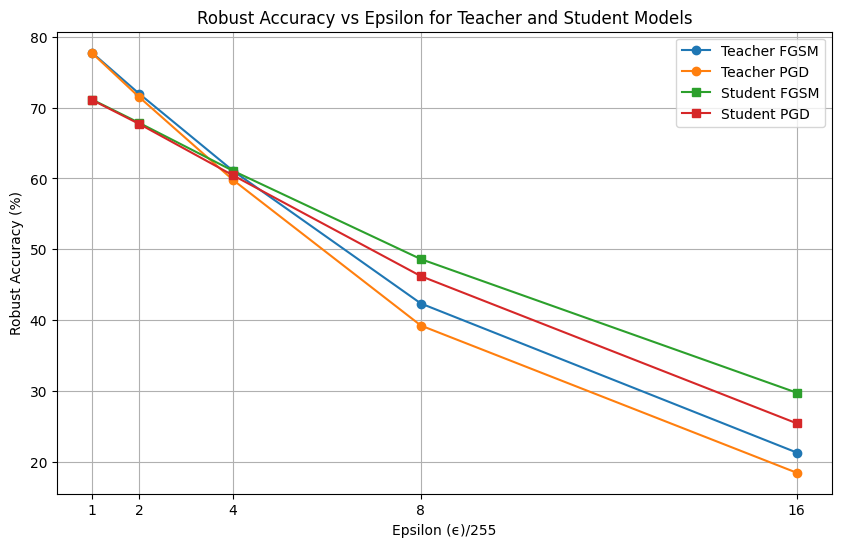

In [14]:
import matplotlib.pyplot as plt

epsilons = [1, 2, 4, 8, 16]

teacher_fgsm = [77.74, 71.97, 61.08, 42.36, 21.34]
teacher_pgd = [77.68, 71.49, 59.79, 39.25, 18.49]

student_fgsm = [71.13, 67.85, 61.08, 48.62, 29.78]
student_pgd = [71.07, 67.70, 60.44, 46.22, 25.46]

plt.figure(figsize=(10, 6))
plt.plot(epsilons, teacher_fgsm, marker='o', label='Teacher FGSM')
plt.plot(epsilons, teacher_pgd, marker='o', label='Teacher PGD')
plt.plot(epsilons, student_fgsm, marker='s', label='Student FGSM')
plt.plot(epsilons, student_pgd, marker='s', label='Student PGD')

plt.title('Robust Accuracy vs Epsilon for Teacher and Student Models')
plt.xlabel('Epsilon (ϵ)/255')
plt.ylabel('Robust Accuracy (%)')
plt.legend()
plt.grid(True)
plt.xticks(epsilons)
plt.show()


# Transferring Adversarial Examples (15 points)

Train yet another model to be used as the surrogate. (set temperature to 1)

In [15]:
model = resnet18(weights=None).to(device)
model.fc = nn.Linear(model.fc.in_features, 10).to(device)

train_teacher(model, n_epochs=15, temp=1)


Epoch [1/15], Loss: 1.5526, Accuracy: 43.12%
Epoch [2/15], Loss: 1.1924, Accuracy: 57.35%
Epoch [3/15], Loss: 1.0214, Accuracy: 63.82%
Epoch [4/15], Loss: 0.9133, Accuracy: 67.62%
Epoch [5/15], Loss: 0.8353, Accuracy: 70.80%
Epoch [6/15], Loss: 0.7770, Accuracy: 72.92%
Epoch [7/15], Loss: 0.7352, Accuracy: 74.40%
Epoch [8/15], Loss: 0.6915, Accuracy: 75.81%
Epoch [9/15], Loss: 0.6558, Accuracy: 77.31%
Epoch [10/15], Loss: 0.6208, Accuracy: 78.40%
Epoch [11/15], Loss: 0.5970, Accuracy: 79.24%
Epoch [12/15], Loss: 0.5831, Accuracy: 79.60%
Epoch [13/15], Loss: 0.5570, Accuracy: 80.51%
Epoch [14/15], Loss: 0.5352, Accuracy: 81.35%
Epoch [15/15], Loss: 0.5177, Accuracy: 82.01%


Print the surrogate accuracy.

In [16]:
surrogate_accuracy = test_clean(model)
print(f'Surrogate Accuracy {surrogate_accuracy:.2f}%')


Surrogate Accuracy 80.23%


Report the accuracy of the surrogate for `ϵ = [1, 2, 4, 8, 16]`.

In [17]:
epsilons = [1, 2, 4, 8, 16]

print("Robust Accuracy of the Surrogate Model:")
for eps in epsilons:
    acc_fgsm = test_attack(model, epsilon=eps/255, attack=attack_fgsm, loader=testloader)
    print(f'FGSM with ϵ={eps}/255 has Accuracy: {acc_fgsm:.2f}%')
    
    acc_pgd = test_attack(model, epsilon=eps/255, attack=attack_pgd, loader=testloader)
    print(f'PGD  with ϵ={eps}/255 has Accuracy: {acc_pgd:.2f}%')


Robust Accuracy of the Surrogate Model:
FGSM with ϵ=1/255 has Accuracy: 76.47%
PGD  with ϵ=1/255 has Accuracy: 76.46%
FGSM with ϵ=2/255 has Accuracy: 72.60%
PGD  with ϵ=2/255 has Accuracy: 72.29%
FGSM with ϵ=4/255 has Accuracy: 64.32%
PGD  with ϵ=4/255 has Accuracy: 63.48%
FGSM with ϵ=8/255 has Accuracy: 47.95%
PGD  with ϵ=8/255 has Accuracy: 44.92%
FGSM with ϵ=16/255 has Accuracy: 25.64%
PGD  with ϵ=16/255 has Accuracy: 21.80%


Implement the following functions to transfer attacks from a surrogate model to an oracle.

In [18]:
def transfer_attack(oracle, model, eps, loader=testloader):
    oracle.eval()
    model.eval()
    
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        perturbed_inputs = attack_fgsm(model, inputs, labels, eps)
        
        outputs = oracle(perturbed_inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    robust_accuracy = 100 * correct / total
    return robust_accuracy


Transfer attacks for `ϵ = [1, 2, 4, 8, 16]` from your model to the student.

In [19]:
for eps in epsilons:
    acc = transfer_attack(student, model, eps/255)
    print(f'FGSM with ϵ={eps}/255 has Accuracy: {acc:.2f}%')

FGSM with ϵ=1/255 has Accuracy: 79.11%
FGSM with ϵ=2/255 has Accuracy: 77.99%
FGSM with ϵ=4/255 has Accuracy: 75.48%
FGSM with ϵ=8/255 has Accuracy: 69.97%
FGSM with ϵ=16/255 has Accuracy: 59.33%


- What can be inferred from these results?
- How are the accuracies of the student and the surrogate under attack related?
- Does Defensive Distillation obfuscate the gradients? Why?

---

### **Answer: Insights from Robust Accuracy Results**

1. **Enhanced Robustness through Defensive Distillation:**
   - The **student model** shows better resilience to stronger adversarial attacks (e.g., `ϵ=8/255` and `ϵ=16/255`) compared to the teacher model. Even though the student has a slightly lower clean accuracy, its ability to maintain higher accuracy under stronger perturbations suggests that defensive distillation helps improve model robustness against adversarial examples.

2. **How are the Accuracies of the Student and Surrogate Related?**
   - Both the **student** and **surrogate models** display similar patterns in terms of robust accuracy under FGSM attacks. This means that adversarial examples generated by the surrogate model can also affect the student model. The attacks are transferable, indicating that adversarial examples are still potent even when the student is trained with defensive distillation.

3. **Does Defensive Distillation Obfuscate the Gradients?**
   - **No, defensive distillation doesn't obfuscate gradients.** The fact that adversarial attacks from the surrogate model are still effective on the student suggests that defensive distillation does **not** hide or distort gradient information. This implies that gradient-based attacks, like FGSM, can still exploit the model effectively.

---

### **Key Takeaways**

- **Defensive Distillation:** While it does improve robustness against strong adversarial attacks, there's a slight loss in clean accuracy.
  
- **Attack Transferability:** Adversarial examples from the surrogate model are still effective against the student model, meaning defensive distillation doesn't fully protect against gradient-based attacks.
  
- **Gradient Access:** The fact that attacks transfer easily shows that defensive distillation doesn't obfuscate gradients, keeping them accessible for adversarial attack methods.

---

These observations suggest that defensive distillation can make models more robust against stronger attacks but doesn't make them immune to gradient-based attacks. More defense techniques might be needed to further protect models.

---


# ZOO Based Black-Box Attacks (25 points)

Based on [Black-box Adversarial Attacks with Limited Queries and Information](https://arxiv.org/abs/1804.08598) you must first calculate the estimate of the graidents, and next attack the model based on your estimates.

In [20]:
def nes_gradient_estimate(model, x, y, epsilon, num_samples, sigma):
    model.eval()  
    batch_size = x.shape[0]
    device = x.device
    
    grad_estimates = torch.zeros_like(x).to(device)
    
    for _ in range(num_samples):
        noise = torch.randn_like(x).to(device) * sigma
        x_pos = torch.clamp(x + noise, lower_limit, upper_limit)
        x_neg = torch.clamp(x - noise, lower_limit, upper_limit)
        
        outputs_pos = model(x_pos)
        loss_pos = F.cross_entropy(outputs_pos, y)
        
        outputs_neg = model(x_neg)
        loss_neg = F.cross_entropy(outputs_neg, y)
        
        loss_diff = (loss_pos - loss_neg) / (2 * sigma)
        
        grad_estimates += loss_diff * noise
    
    grad_estimates /= num_samples
    
    return grad_estimates


In [21]:
def partial_information_attack(model, x, y, epsilon, num_samples, sigma, num_steps, alpha):

    model.eval()
    
    adv_x = x.clone().detach().to(device)
    
    for step in range(num_steps):
        grad_est = nes_gradient_estimate(model, adv_x, y, epsilon, num_samples, sigma)
        
        adv_x = adv_x + alpha * grad_est.sign()
        
        adv_x = torch.clamp(adv_x, x - epsilon, x + epsilon)
        
        adv_x = torch.max(torch.min(adv_x, upper_limit), lower_limit).detach()
    
    return adv_x


Now run this attack on your models and report the results. (You **DON'T** need to run the attack for the entire test dataset as this will take a lot of time!)

In [ ]:
from torch.utils.data import Subset

def run_zoo_attack(oracle, surrogate, epsilon, num_samples, sigma, num_steps, alpha, loader=testloader, subset_size=100):
    oracle.eval()
    surrogate.eval()
    
    subset_indices = list(range(subset_size))
    subset = Subset(loader.dataset, subset_indices)
    subset_loader = DataLoader(subset, batch_size=32, shuffle=False)
    
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(subset_loader, desc="ZOO Attack Progress"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        adv_inputs = partial_information_attack(
            model=surrogate,
            x=inputs,
            y=labels,
            epsilon=epsilon,
            num_samples=num_samples,
            sigma=sigma,
            num_steps=num_steps,
            alpha=alpha
        )
        
        with torch.no_grad():
            outputs = oracle(adv_inputs)
            _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    robust_accuracy = 100 * correct / total
    return robust_accuracy

epsilon = 8/255       
num_samples = 100     
sigma = 0.01          
num_steps = 10        
alpha = 0.2           
subset_size = 100     

robust_accuracy_zoo = run_zoo_attack(
    oracle=student,      
    surrogate=model,     
    epsilon=epsilon,
    num_samples=num_samples,
    sigma=sigma,
    num_steps=num_steps,
    alpha=alpha,
    loader=testloader,
    subset_size=subset_size
)

print(f'ZOO Attack with ϵ={epsilon*255}/255 on {subset_size} samples has Oracle Accuracy: {robust_accuracy_zoo:.2f}%')


ZOO Attack Progress:  25%|██▌       | 1/4 [1:46:26<5:19:19, 6386.62s/it]

# Adversarially Robust Distillation (15 points)

In this section we are going to test another type of distillation to see if this method is robust. This technique is [Adversarially Robust Distillation](https://arxiv.org/abs/1905.09747).



1.   We will try to distill a robsut teacher from [Robust Bench](https://robustbench.github.io/) onto a smaller architecture.
2.   We minimize the KL-Divergence between the logits of the student and teacher to ensure fidelity. (You can also incorporate the classification loss as mentioned in the paper but you can choose to ignore it as well)
3.   At each step of the distillation you will attack the student (you can use either FGSM or PGD) and find an adversarial example $X + \delta$ for data point $X$. Next you will minimize $t^2 \times \text{KL}(S(X+\delta), T(X))$ where $S$ and $T$ are the student and teacher networks respectively.



In [ ]:
! pip install git+https://github.com/RobustBench/robustbench.git

  Cloning https://github.com/RobustBench/robustbench.git to /tmp/pip-req-build-j7zow56s
  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git /tmp/pip-req-build-j7zow56s
  Resolved https://github.com/RobustBench/robustbench.git to commit 776bc95bb4167827fb102a32ac5aea62e46cfaab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached autoattack-0.1-py3-none-any.whl


In [ ]:
from robustbench.utils import load_model

teacher = load_model(model_name='Gowal2021Improving_R18_ddpm_100m', dataset='cifar10', threat_model='Linf')

TypeError: 'type' object is not subscriptable

In [ ]:
def ard(student, teacher, dataloader, optimizer, eps, attack):
    student.train()
    teacher.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    loss_fn = nn.KLDivLoss(reduction='batchmean')
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        adv_inputs = attack(student, inputs, labels, eps)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs) 
        student_outputs = student(adv_inputs) 
        
        soft_labels = F.log_softmax(student_outputs, dim=1)
        teacher_soft = F.softmax(teacher_outputs, dim=1)
        
        loss = loss_fn(soft_labels, teacher_soft)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(student_outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(dataloader)
    avg_accuracy = 100 * correct / total
    return avg_loss, avg_accuracy

def adv_train_student(model, teacher, n_epochs, eps=8/255, loader=trainloader):
    optimizer = Adam(model.parameters(), lr=0.001)
    
    for epoch in range(n_epochs):
        epoch_loss, epoch_accuracy = ard(model, teacher, loader, optimizer, eps, attack=attack_fgsm)
        
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


In [ ]:
student = mobilenet_v2(weights=None).to(device)

student.classifier[1] = nn.Linear(student.classifier[1].in_features, 10).to(device)

adv_train_student(student, teacher, n_epochs=15, eps=8/255, loader=trainloader)


Epoch [1/15], Loss: 1.9442, Accuracy: 9.89%
Epoch [2/15], Loss: 1.9430, Accuracy: 10.02%
Epoch [3/15], Loss: 1.9454, Accuracy: 9.95%
Epoch [4/15], Loss: 1.9459, Accuracy: 10.11%
Epoch [5/15], Loss: 1.9454, Accuracy: 9.94%
Epoch [6/15], Loss: 1.9445, Accuracy: 9.93%
Epoch [7/15], Loss: 1.9441, Accuracy: 9.93%
Epoch [8/15], Loss: 1.9442, Accuracy: 10.00%
Epoch [9/15], Loss: 1.9435, Accuracy: 10.00%
Epoch [10/15], Loss: 1.9434, Accuracy: 10.00%
Epoch [11/15], Loss: 1.9425, Accuracy: 10.00%
Epoch [12/15], Loss: 1.9452, Accuracy: 10.00%
Epoch [13/15], Loss: 1.9427, Accuracy: 10.00%
Epoch [14/15], Loss: 1.9434, Accuracy: 10.00%
Epoch [15/15], Loss: 1.9441, Accuracy: 10.00%


Now report the accuracy of the student on the test dataset.

In [ ]:
def test_clean(model, dataloader=testloader):
    model.eval() 
    correct = 0
    total = 0
    
    with torch.no_grad():  
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

clean_accuracy = test_clean(student)
print(f'Student Clean Accuracy: {clean_accuracy:.2f}%')

fgsm_acc = test_attack(student, epsilon=8/255, attack=attack_fgsm, loader=testloader)
print(f'Student FGSM with ϵ=8/255 has Accuracy: {fgsm_acc:.2f}%')

pgd_acc = test_attack(student, epsilon=8/255, attack=attack_pgd, loader=testloader)
print(f'Student PGD  with ϵ=8/255 has Accuracy: {pgd_acc:.2f}%')


Student Clean Accuracy: 10.00%
Student FGSM with ϵ=8/255 has Accuracy: 10.00%
Student PGD  with ϵ=8/255 has Accuracy: 10.00%
